In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
import matplotlib.pyplot as plt
import scipy as sc
from scipy.optimize import minimize
from sklearn.datasets import make_regression
from sklearn import linear_model
import tensorflow as tf


Generating and Importing dataframe

In [2]:
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
import sklearn.datasets as dt

rng = np.random.RandomState(1)
X = rng.rand(1000, 2)
Y = np.dot(X, [3, -2])

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=1) # Generating train and test dataset

min_val_x = X.min()
max_val_x = X.max()

min_val_y = Y.min()
max_val_y = Y.max()

X_train = (X_train - min_val_x) / (max_val_x - min_val_x)
X_test = (X_test - min_val_x) / (max_val_x - min_val_x)

#Y_train = (Y_train - min_val_y) / (max_val_y - min_val_y)
#Y_test = (Y_test - min_val_y) / (max_val_y - min_val_y)

Lasso regression using scikit-learn library

C:\Users\patel\AppData\Local\Temp\ipykernel_20408\3099030198.py:23: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model_lasso.fit(X_train,Y_train)    # training the model
e:\Lectures\Arbeit\Sensorics\sens\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


      NRMSE         0         1  alpha
0  0.000112  2.995025 -1.996504  0.000
1  0.005081  2.982109 -1.984293  0.001
2  0.049883  2.865864 -1.874392  0.010
3  0.497942  1.703336 -0.775318  0.100
4  1.113842  0.000000  0.000000  1.000


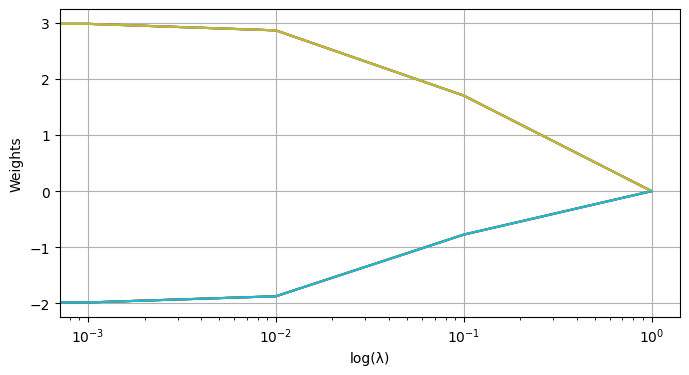

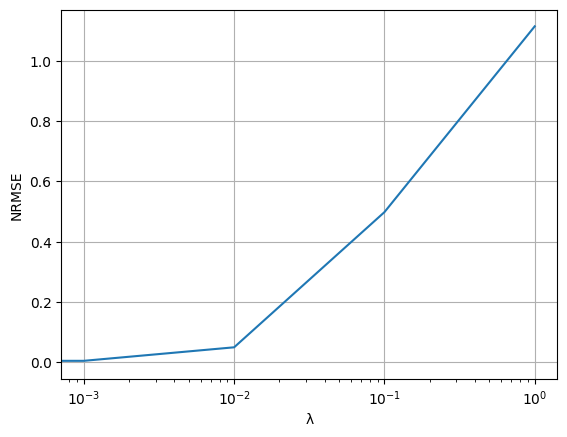

In [3]:
from sklearn.linear_model import Lasso
from importlib import reload
plt = reload(plt)

lamda = [0,0.001,0.01,0.1,1]   # an array with differnet values of tuning parameter

cf_lasso = []   # array of co-efficients for different lamda
r2_scores_lasso = []    # array of r2 scores for different lamda
intercept=[]    # array of biases for different lamda
NRMSE_s = []

def NRMSE(y,ym):
        # y: Process output, ym: Model output or predictions
        error = np.zeros(len(y))

        for i in range(len(y)):
            error[i] = (y[i]-ym[i])**2
            
        return np.sqrt(np.mean((error)/np.char.chararray.var(y)))

for i in lamda:
    model_lasso = Lasso(alpha = i,fit_intercept=False,max_iter=10000,tol=1e-4)
    model_lasso.fit(X_train,Y_train)    # training the model

    cf_lasso.append(model_lasso.coef_.tolist())
    ym_lasso = model_lasso.predict(X_test)  # Generating model output
    r2_scores_lasso.append(r2_score(Y_test,ym_lasso))
    NRMSE_s.append(NRMSE(Y_test,ym_lasso))

# Genarating daframe with lamdas, r2_score, bias and co-efficients
df_lasso = pd.DataFrame(cf_lasso)
df_lasso['alpha'] = lamda
df_lasso.set_index('alpha')
#df_lasso.insert(loc=0,column= 'r2_score',value=r2_scores_lasso)
df_lasso.insert(loc=0,column= 'NRMSE',value=NRMSE_s)

print(df_lasso.head())

# Plotting diffenent values of lamda vs co-efficients
nwl,_ = np.array(cf_lasso).shape
plt.figure(figsize = (8,4))

for i in range(nwl):
    plt.plot(lamda, cf_lasso)

plt.xscale('log')
plt.xlabel('log(\u03BB)')
plt.ylabel('Weights')
plt.axis('tight')
plt.grid()
plt.show()

plt.plot(lamda,NRMSE_s)
plt.xscale('log')
plt.xlabel('\u03BB')
plt.ylabel('NRMSE')
plt.axis('tight')
plt.grid()
plt.show()


Creating class Coordinate Descent without Bias

In [6]:
import copy

class CoordinateDescentLassoWithoutBias():
    def __init__(self, alpha, epoch= 10000,tol = 1e-4):
        self.alpha = alpha  
        self.epoch = epoch 
        self.tol = tol 
        self.coef = None
        self.para = None 

    def soft_threshold(self,rho,lamda):
        if rho < - lamda:
            return rho + lamda
        elif rho > lamda:
            return rho - lamda
        else: 
            return 0
    
    def fit(self, X, y):
        m,n = X.shape
        beta = [2,2]  
        para = []      

        for iteration in range(self.epoch):
            beta_old = np.copy(beta)
            
            for j in range(n):
                beta[j] = 0.0
                error = y - np.dot(X, beta)
                rho = np.dot(X[:, j], error)
                lamda = self.alpha*m

                beta[j] = self.soft_threshold( rho, lamda) / (X[:, j]**2).sum() 
                para.append(copy.deepcopy(beta))   

            if np.linalg.norm(beta - beta_old) < self.tol:
                print("Optimization converged after", iteration+1, "iterations")
                break       
    
        self.coef = beta
        self.para = para
        return self

    def predict(self, X):        
        y = np.dot(X, self.coef)        
        return y
    
    def NRMSE(self,y,ym):
        # y: Process output, ym: Model output or predictions
        error = np.zeros(len(y))

        for i in range(len(y)):
            error[i] = (y[i]-ym[i])**2
            
        return np.sqrt(np.mean((error)/np.char.chararray.var(y)))


Implementation of Coordinate Descent without Bias

In [7]:
w_wo = []
r2_scores_wo= []
NRMSE_wo = []

for i in lamda:
    model = CoordinateDescentLassoWithoutBias(i)
    model.fit(X_train,Y_train)
    
    w_wo.append(model.coef)
    ym_wo = model.predict(X_test)
    r2_scores_wo.append(r2_score(Y_test,ym_wo))
    NRMSE_wo.append(model.NRMSE(Y_test,ym_wo)) 

df_wo = pd.DataFrame(w_wo)
df_wo.insert(loc=0,column= 'r2_score',value=r2_scores_wo)
df_wo.insert(loc=0,column= 'NRMSE',value=NRMSE_wo)
df_wo['lamda'] = lamda
df_wo.set_index('lamda')

print(df_wo.head())

'''nwo,_ = np.array(w_wo).shape
plt.figure(figsize = (8,4))

for i in range(nwo):
    plt.plot(lamda, w_wo)

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('Coefficients')
plt.title('Lasso without Bias')
plt.axis('tight')
plt.grid()
plt.show()

plt.plot(lamda,NRMSE_wo)
plt.xlabel('Lamda')
plt.ylabel('NRMSE')
plt.axis('tight')
plt.grid()
plt.show()'''


Optimization converged after 21 iterations
Optimization converged after 21 iterations
Optimization converged after 20 iterations
Optimization converged after 18 iterations
Optimization converged after 2 iterations
      NRMSE  r2_score         0         1  lamda
0  0.000042  1.000000  2.995248 -1.996666  0.000
1  0.005002  0.999975  2.982331 -1.984454  0.001
2  0.049825  0.997517  2.866030 -1.874512  0.010
3  0.497913  0.752082  1.703417 -0.775377  0.100
4  1.113842 -0.240644  0.000000  0.000000  1.000


"nwo,_ = np.array(w_wo).shape\nplt.figure(figsize = (8,4))\n\nfor i in range(nwo):\n    plt.plot(lamda, w_wo)\n\nplt.xscale('log')\nplt.xlabel('Log($\\lambda$)')\nplt.ylabel('Coefficients')\nplt.title('Lasso without Bias')\nplt.axis('tight')\nplt.grid()\nplt.show()\n\nplt.plot(lamda,NRMSE_wo)\nplt.xlabel('Lamda')\nplt.ylabel('NRMSE')\nplt.axis('tight')\nplt.grid()\nplt.show()"

In [8]:
lasso = CoordinateDescentLassoWithoutBias(1,epoch=1000)
lasso.fit(X_train,Y_train)
    
w_o = lasso.coef
y_o = lasso.predict(X_test)
r2_scores_wo = r2_score(Y_test,y_o)
NRMSE_wo = lasso.NRMSE(Y_test,y_o)

#beta_1 = lasso.para[0::2]
#beta_2 = lasso.para[1::2]

beta_1 = [b[0] for b in lasso.para]
beta_2 = [b[1] for b in lasso.para]

print(lasso.para)
print(NRMSE_wo)

Optimization converged after 2 iterations
[[0.0, 2], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]]
1.1138418754616883


Plot of coordinate descent algorrythm

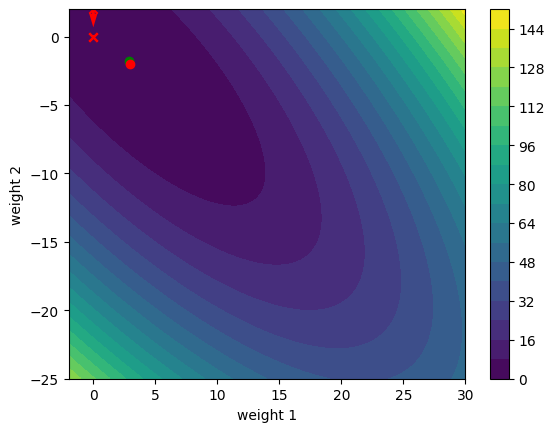

Nelder Mead: [ 2.98251493 -1.98451506]
[0.0, 0.0]


In [9]:
n = 100
xlist = np.linspace(-2,30,n)
ylist = np.linspace(-25,2,n)
X_l, Y_l = np.meshgrid(xlist, ylist)
def loss(beta,X,y):        
        loss = (0.5/X.shape[0])*np.linalg.norm((y- np.squeeze(X.dot(beta))),ord=2)**2 + 0.001* np.linalg.norm(beta,ord=1)     
        
        return loss 

mse_vals = np.zeros(shape=(n,n))
for i in range(n):
    for j in range(n):
        w = np.atleast_1d(X_l[i,j], Y_l[i,j])
        mse_vals[i,j] = loss(w,X_train,Y_train)

result = np.where(mse_vals == np.amin(mse_vals))

beta = np.zeros(2)


res = minimize(loss, x0=beta,args=(X_train,Y_train), method='COBYLA', jac = False)
#res_nm = minimize(loss, x0=beta,args=(X_train,Y_train), method='Nelder-Mead', jac = False)

beta = res.x
#beta_nm = res_nm.x

fig, ax = plt.subplots()
cp = ax.contourf(X_l, Y_l, (mse_vals), levels=20)
plt.colorbar(cp)
plt.xlabel('weight 1')
plt.ylabel('weight 2')
#plt.title('Lasso Regression Loss Function Contour Plot')
plt.scatter(beta_1, beta_2, color='red',marker='x')
ax.quiver(np.array(beta_1[:-1]), np.array(beta_2[:-1]), np.array(beta_1[1:])-np.array(beta_1[:-1]), np.array(beta_2[1:])-np.array(beta_2[:-1]), 
          scale_units='xy', angles='xy', scale=1.5, color='r')
plt.scatter(X_l[result[0],result[1]],Y_l[result[0],result[1]],color= 'g')
plt.scatter(res.x[0],res.x[1],color = 'red',marker= 'o')

plt.show()
#print(result)
#print(f"l-BFGS:  {res.x}")
print(f"Nelder Mead: {res.x}")
print(w_o)


Nelder Mead optimizer

In [11]:
class optimize_nm(CoordinateDescentLassoWithoutBias):
    def __init__(self, alpha, epoch= 1000):
        self.alpha = alpha  
        self.epoch = epoch  
        self.coef_l = None 
        self.coef_nm = None
        self.bias = None 
        self.his = None

    def loss(self,beta,X,y):     
        loss = (0.5/X.shape[0])*np.linalg.norm((y- np.squeeze(X.dot(beta))),ord=2)**2 + self.alpha* np.linalg.norm(beta,ord=1)
        return loss    
    
    def fit(self, X, y):      
        m,n = X.shape
        beta = [2,2]

        x_history = []
        def callback(xk):
            x_history.append(xk)            

        #for j in range(n):
        res_nm = minimize(self.loss, x0=beta,args=(X,y), method='Nelder-Mead', jac=False,callback=callback,tol=1e-4)
        beta = res_nm.x
            
        self.coef_nm = beta
        print("Iterations: ", res_nm.nfev)       
        
        self.his = x_history
        return self
    
    def predict(self, X):        
        y = np.dot(X, self.coef_nm)        
        return y
    
    def NRMSE(self,y,ym):
        # y: Process output, ym: Model output or predictions
        error = np.zeros(len(y))

        for i in range(len(y)):
            error[i] = (y[i]-ym[i])**2
            
        return np.sqrt(np.mean((error)/np.char.chararray.var(y)))

In [12]:
opt_nm = optimize_nm(1)
opt_nm.fit(X_train,Y_train)    

w_nm = opt_nm.coef_nm
y_nm = opt_nm.predict(X_test)
NRMSE_nm = opt_nm.NRMSE(Y_test,y_nm)
his = np.array(opt_nm.his)
print(w_nm,NRMSE_nm)
para_1 = his[:,0]
para_2 = his[:,1]

Iterations:  101
[2.33453056e-05 9.90409706e-06] 1.1138318703201173


Plot of Nelder Mead optmiazation

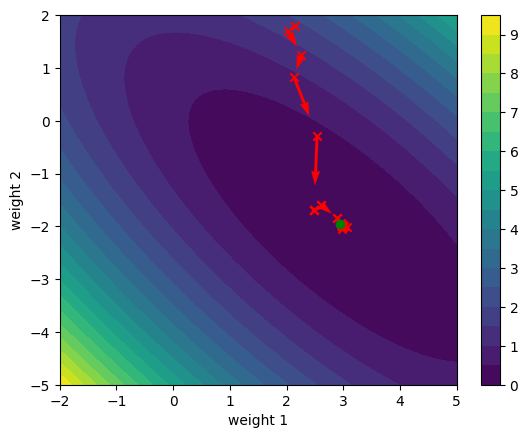

In [22]:
fig, ax = plt.subplots()
cp = ax.contourf(X_l, Y_l, (mse_vals), levels=20)
plt.colorbar(cp)
plt.xlabel('weight 1')
plt.ylabel('weight 2')
#plt.title('Lasso Regression Loss Function Contour Plot')
plt.scatter(para_1, para_2, color='red',marker='x')
ax.quiver(np.array(para_1[:-1]), np.array(para_2[:-1]), np.array(para_1[1:])-np.array(para_1[:-1]), np.array(para_2[1:])-np.array(para_2[:-1]), 
          scale_units='xy', angles='xy', scale=1.5, color='r')
plt.scatter(X_l[result[0],result[1]],Y_l[result[0],result[1]],color= 'g')

LARS

[0. 0.] [0. 0.] 0
[0.0, 0.0]


e:\Lectures\Arbeit\Sensorics\sens\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


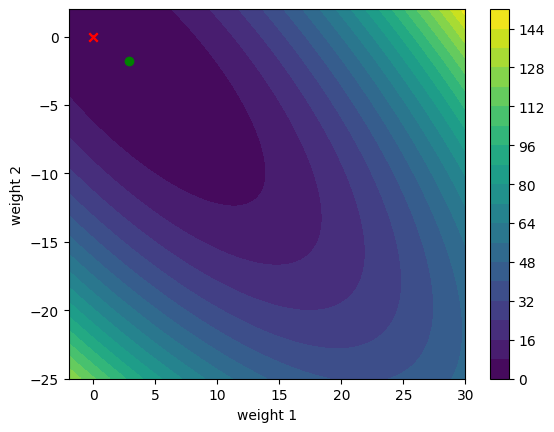

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoLars


reg =LassoLars(alpha=1.0,max_iter=10000000,eps=1e-8)

reg.fit(X_train,Y_train)
coef_path = reg.coef_path_
final_coeff1 = reg.coef_[0]
final_coeff2 = reg.coef_[1]
coeff1_values = coef_path[0, :]
coeff2_values = coef_path[1, :]
weight_1 = np.append(coeff1_values, final_coeff1)
weight_2 = np.append(coeff2_values, final_coeff2)

fig, ax = plt.subplots()
cp = ax.contourf(X_l, Y_l, (mse_vals), levels=20)
plt.colorbar(cp)
plt.xlabel('weight 1')
plt.ylabel('weight 2')
#plt.title('Lasso Regression Loss Function Contour Plot')
plt.scatter(weight_1, weight_2, color='red',marker='x')
ax.quiver(np.array(weight_1[:-1]), np.array(weight_2[:-1]), np.array(weight_1[1:])-np.array(weight_1[:-1]), np.array(weight_2[1:])-np.array(weight_2[:-1]), 
          scale_units='xy', angles='xy', scale=1.5, color='r')
plt.scatter(X_l[result[0],result[1]],Y_l[result[0],result[1]],color= 'g')

print(weight_1,weight_2,reg.n_iter_)
print(w_o)

In [46]:
y_la = reg.predict(X_test)
print(NRMSE(Y_test,y_la))

0.040582347419824645


Gradient Descent

In [13]:
lasso = CoordinateDescentLassoWithoutBias(0.1,epoch=1000)
lasso.fit(X_train,Y_train)
    
w_o = lasso.coef
y_o = lasso.predict(X_test)
r2_scores_wo = r2_score(Y_test,y_o)
NRMSE_wo = lasso.NRMSE(Y_test,y_o)

#beta_1 = lasso.para[0::2]
#beta_2 = lasso.para[1::2]

beta_1 = [b[0] for b in lasso.para]
beta_2 = [b[1] for b in lasso.para]

print(w_o)

Optimization converged after 6 iterations
[0.5837902211496655, 0.0]


In [14]:
init_slope = np.ones(2)

def run_gradient_descent(X, Y,learning_rate,epochs = 800):
   init_slope = np.ones(X.shape[1])
   tf_slope = tf.Variable(init_slope, dtype='float32') 

   def soft_threshold(rho,lamda):
        rho_np = rho.numpy()
        if np.all(rho_np < -lamda):
            return rho + lamda
        elif np.all(rho_np > lamda):
            return rho - lamda
        else:
            return tf.zeros_like(rho)
        
   iter = 0

   for i in range(epochs):
        with tf.GradientTape() as tape:
            tape.watch(tf_slope)

            # This is the same mean-squared-error calculation as before
            X_float32 = tf.cast(X, dtype='float32')


            predictions = tf.linalg.matmul( (X_float32),tf.expand_dims(tf_slope, axis=1))
            Y_reshaped = tf.cast(tf.reshape(Y, (-1, 1)), dtype=tf.float32)
            
            loss = (0.5 / X.shape[0]) * tf.reduce_sum(tf.square(Y_reshaped - predictions)) + 0.01 * tf.norm(tf_slope, ord=1)        
            

        # Auto-diff magic!  Calcs gradients between loss calc and params
        dloss_dparams = tape.gradient(loss, tf_slope)       
        
       
        # Gradients point towards +loss, so subtract to "descend"
        tf_slope.assign_sub(learning_rate * dloss_dparams)
        #tf_slope.assign(soft_threshold(tf_slope, 1e-3)) 
        print(tf_slope)       
       
   return tf_slope

In [15]:
y = run_gradient_descent(X_train, Y_train,0.01,epochs=10000)
print(y)
print(w_o)

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([0.99698627, 0.9959811 ], dtype=float32)>
<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([0.99399257, 0.9919842 ], dtype=float32)>
<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([0.9910188, 0.9880092], dtype=float32)>
<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([0.98806477, 0.984056  ], dtype=float32)>
<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([0.9851304 , 0.98012435], dtype=float32)>
<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([0.98221564, 0.97621423], dtype=float32)>
<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([0.97932035, 0.9723255 ], dtype=float32)>
<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([0.97644436, 0.968458  ], dtype=float32)>
<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([0.9735876 , 0.96461165], dtype=float32)>
<tf.Variable 'Variable:0' shape=(2,) dtype=float